In [1]:
import os
import sys; print('Python %s on %s' % (sys.version, sys.platform))
sys.path.extend([os.path.abspath('..')])

Python 3.10.12 | packaged by Anaconda, Inc. | (main, Jul  5 2023, 19:01:18) [MSC v.1916 64 bit (AMD64)] on win32


In [ ]:
from nilearn import plotting
from nilearn.connectome import ConnectivityMeasure
import matplotlib.pyplot as plt

In [56]:
import warnings
from pathlib import Path

import bids
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd
from nilearn import plotting
from nilearn.connectome import ConnectivityMeasure
from nilearn.interfaces.fmriprep import load_confounds
from nilearn.maskers import NiftiLabelsMasker
from scipy.io import loadmat
import os
#from utils.helpers import *

warnings.filterwarnings("ignore", category=FutureWarning)


user_path = os.path.expanduser("~")


class Dataset:

    def __init__(self, sub_label: list, derivatives_path: str, 
                 atlas_path: str, atlas_labels_path: str,
                 strategy: int, n_compcorr=None,
                 use_GSR=False, use_cosine=True,
                 ):
        """ """
        self.sub_labels = sub_label
        self.derivatives = Path(derivatives_path).as_posix()
        self.atlas_filename = nib.load(Path(atlas_path).as_posix())
        self.atlas_labels_path = Path(atlas_labels_path).as_posix()
        self.int_strategy = strategy
        self.use_cosine = use_cosine
        self.use_GSR = use_GSR

    @property
    def bids_layout(self):
        return bids.BIDSLayout(
            self.derivatives, validate=False, config=['bids','derivatives'])
    
    @property
    def atlas_labels(self): # TODO не только excel
        roi = pd.read_excel(self.atlas_labels_path, index_col='Index')
        roi_labels = roi.sort_values(by='ID').Label.values
        return {'roi_df': roi, 'roi_labels': roi_labels}
    
    @property
    def strategy(self):
        strategy_1 = {'strategy': ['motion', 'compcor', 'high_pass'],
                      'motion': 'full',
                      'compcor': 'anat_combined',
                      'n_compcor': 10}
        
        if self.use_GSR:
            strategy_1['strategy'].append('global_signal')
            strategy_1['global_signal'] = 'basic' # TODO выбирать опции
        
        return strategy_1

    #@property
    def get_confounds(self, imgs):
        
        confounds, _ = load_confounds(imgs,
                                    strategy=self.strategy['strategy'],
                                    motion=self.strategy['motion'],
                                    compcor=self.strategy['compcor'], 
                                    n_compcor=self.strategy['n_compcor']
                                    )

        if not self.use_cosine:
            for i in confounds:
                i.drop(['cosine00', 'cosine01', 'cosine02'], axis=1, inplace=True)

        return confounds
    
    @property
    def masker(self):
        mask = NiftiLabelsMasker(labels_img=self.atlas_filename,
                                labels=self.atlas_labels['roi_labels'], 
                                memory="nilearn_cache",
                                verbose=2,
                                standardize=True,
                                detrend=True,
                                resampling_target='labels'
                                )
        
        if self.use_cosine is False:
            mask.set_params(high_pass=0.008,
                            low_pass=0.09, 
                            t_r=2.5)
            
        return mask
    
    def denoise(self, sub=None):
        if sub is None:
            sub = self.bids_layout.get_subjects()

        imgs = self.bids_layout.get(subject=sub,
                        datatype='func', task='rest',
                        desc='preproc',
                        space='MNI152NLin2009cAsym',
                        extension='nii.gz',
                        return_type='file')
        
        conf = self.get_confounds(imgs=imgs)
        denoised_ts = np.empty((len(conf), 120, 426)) # TODO shape
        for i in range(len(conf)):
            denoised_ts[i] = self.masker.fit_transform(imgs[i], confounds=conf[i])
        
        return denoised_ts
    
    #@staticmethod
    def functional_connectivity(self, ts, measure="correlation"):
        connectivity_measure = ConnectivityMeasure(kind=measure)
        fc = connectivity_measure.fit_transform(ts)
        for i in fc:
            np.fill_diagonal(i, 0)
        return fc


## dataset

In [3]:
from pathlib import Path
import bids

import nibabel as nib
import numpy as np
import pandas as pd
from nilearn.interfaces.fmriprep import load_confounds


class Dataset:

    def __init__(self, sub_label: list, derivatives_path: str, runs: int,
                 task: str):
        """ 
        
        """
        self.sub_labels = sub_label
        self.derivatives = Path(derivatives_path).as_posix()
        self.runs = runs
        self.task = task


    @property
    def bids_layout(self):
        return bids.BIDSLayout(
            self.derivatives, validate=False, config=['bids','derivatives'])
    
    @property
    def confounds_paths(self):
        conf = self.bids_layout.get(subject=self.sub_labels,
                                    extension='tsv',
                                    return_type='file')
        return conf
    
    @property
    def get_func_files(self):
        return self.bids_layout.get(subject=self.sub_labels,
                                    datatype='func', 
                                    task=self.task,
                                    desc='preproc',
                                    space='MNI152NLin2009cAsym',
                                    extension='nii.gz',
                                    return_type='file')
        
    
    def save_stuff(self):
        pass


    

In [4]:
derivatives_path = r"C:\Users\user\Desktop\open_close_001\derivatives"
sub = ['001', '002']

data = Dataset(sub, derivatives_path)

In [5]:
data.confounds_paths

['C:\\Users\\user\\Desktop\\open_close_001\\derivatives\\sub-001\\func\\sub-001_task-rest_run-1_desc-confounds_timeseries.tsv',
 'C:\\Users\\user\\Desktop\\open_close_001\\derivatives\\sub-001\\func\\sub-001_task-rest_run-2_desc-confounds_timeseries.tsv',
 'C:\\Users\\user\\Desktop\\open_close_001\\derivatives\\sub-002\\func\\sub-002_task-rest_run-1_desc-confounds_timeseries.tsv',
 'C:\\Users\\user\\Desktop\\open_close_001\\derivatives\\sub-002\\func\\sub-002_task-rest_run-2_desc-confounds_timeseries.tsv']

##  atlas

In [ ]:
from pathlib import Path

import nibabel as nib
import numpy as np
import pandas as pd
from nilearn.maskers import NiftiLabelsMasker


class Atlas:
    def __init__(self, atlas_path, atlas_labels, atlas_name):
        self.atlas_path = atlas_path
        self.atlas_name = atlas_name

    @property
    def atlas_labels(self): # TODO не только excel
        roi = pd.read_excel(self.atlas_labels_path, index_col='Index')
        roi_labels = roi.sort_values(by='ID').Label.values
        return {'roi_df': roi, 'roi_labels': roi_labels}

    @property
    def masker(self):
        mask = NiftiLabelsMasker(labels_img=self.atlas_path,
                                 labels=self.atlas_labels, 
                                 memory="nilearn_cache",
                                 verbose=2,
                                 standardize=True,
                                 detrend=True,
                                 resampling_target='labels'
                                 )
        
        #if self.use_cosine is True:
            #mask.set_params(high_pass=0.008,
                            #low_pass=0.09, 
                            #t_r=2.5)
            
        return mask
    


## denoise

In [ ]:
from pathlib import Path
import bids

import nibabel as nib
import numpy as np
import pandas as pd
from nilearn.connectome import ConnectivityMeasure
from nilearn.interfaces.fmriprep import load_confounds


class Denoising:

    def __init__(self, dataset, atlas,
                 strategy, n_compcor=None,
                 use_GSR=False, use_cosine=True,
                 smoothing=None):
        """ 
        
        """
        self.dataset = dataset
        self.atlas = atlas

        self.int_strategy = strategy
        self.use_cosine = use_cosine
        self.use_GSR = use_GSR
        self.smoothing = smoothing
        self.n_compcor = n_compcor    
    
    @property
    def strategy(self):
        strategy_1 = {'strategy': ['motion', 'compcor', 'high_pass'],
                      'motion': 'full',
                      'compcor': 'anat_combined',
                      'n_compcor': 10}
        
        if self.use_GSR:
            strategy_1['strategy'].append('global_signal')
            strategy_1['global_signal'] = 'basic' # TODO выбирать опции
        
        return strategy_1
    
    
    def denoise(self, sub=None, save_outputs=False):
        """ 
        
        """
        if sub is None:
            sub = self.sub_labels

        imgs = self.dataset.get_func_files
        
        conf = self.get_confounds(imgs=imgs)
        denoised_ts = np.empty((len(conf), 120, 426)) # TODO shape
        
        for i in range(len(conf)):
            denoised_ts[i] = self.atlas.masker.fit_transform(imgs[i], confounds=conf[i])

        if save_outputs:
            self.save_outputs(denoised_ts)
        
        return denoised_ts
    
    
    def save_outputs(self, outputs, sub):
        for i in sub:
            path_to_save = os.path.join(data.derivatives, f'sub-{i}', 'time-series', 
                                        self.atlas.atlas_name)
            name = f'sub-{i}_task-{self.dataset.task}_run-{i}'




    def functional_connectivity(self, ts, measure="correlation"):
        connectivity_measure = ConnectivityMeasure(kind=measure)
        fc = connectivity_measure.fit_transform(ts)
        for i in fc:
            np.fill_diagonal(i, 0)

        return fc


In [10]:
data.bids_layout.get_subjects()

['001', '002']

In [9]:
os.listdir(os.path.join(data.derivatives, 'sub-001'))

['anat', 'figures', 'func', 'log']

In [8]:
data.bids_layout

BIDS Layout: ...top\open_close_001\derivatives | Subjects: 2 | Sessions: 0 | Runs: 4

## test

In [44]:
derivatives_path = r'C:\Users\user\Desktop\open_close_001\derivatives'
atlas_path = r'C:\Users\user\YandexDisk\IHB\Projects\OpenCloseFMRI\data\atlas\HCPex_atlas.nii'
atlas_labels_path = r'C:\Users\user\YandexDisk\IHB\Projects\OpenCloseFMRI\data\atlas\HCPex_sorted_v2_networks_names.xlsx'

In [60]:
dataset = Dataset(['001', '002'],
                  derivatives_path=derivatives_path,
                  atlas_path=atlas_path,
                  atlas_labels_path=atlas_labels_path,
                  strategy=1, n_compcorr=10,
                  use_cosine=False)

In [61]:
denoised = dataset.denoise()

[NiftiLabelsMasker.wrapped] loading data from Nifti1Image('C:\Users\user\YandexDisk\IHB\Projects\OpenCloseFMRI\data\atlas\HCPex_atlas.nii')
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('C:\\Users\\user\\Desktop\\open_close_001\\derivatives\\sub-001\\func\\sub-001_task-rest_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', 
{ 'background_label': 0,
  'clean_kwargs': {},
  'detrend': True,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': array(['Primary_Visual_Cortex_L', ..., 'Nuclei_basal_R'], dtype=object),
  'labels_img': <nibabel.nifti1.Nifti1Image object at 0x000002C99C35DA80>,
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': array([[   1.,    0.,    0.,  -96.],
       [

In [62]:
denoised.shape

(4, 120, 426)

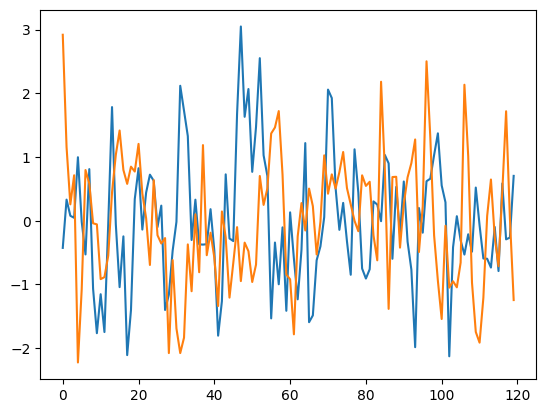

In [63]:
plt.plot(denoised[3, :, 0])
plt.plot(denoised[2, :, 0])

In [64]:
correlation_matrix = dataset.functional_connectivity(denoised[:2])

c:\ProgramData\Anaconda3\envs\nilearn\lib\site-packages\nilearn\plotting\matrix_plotting.py:293: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


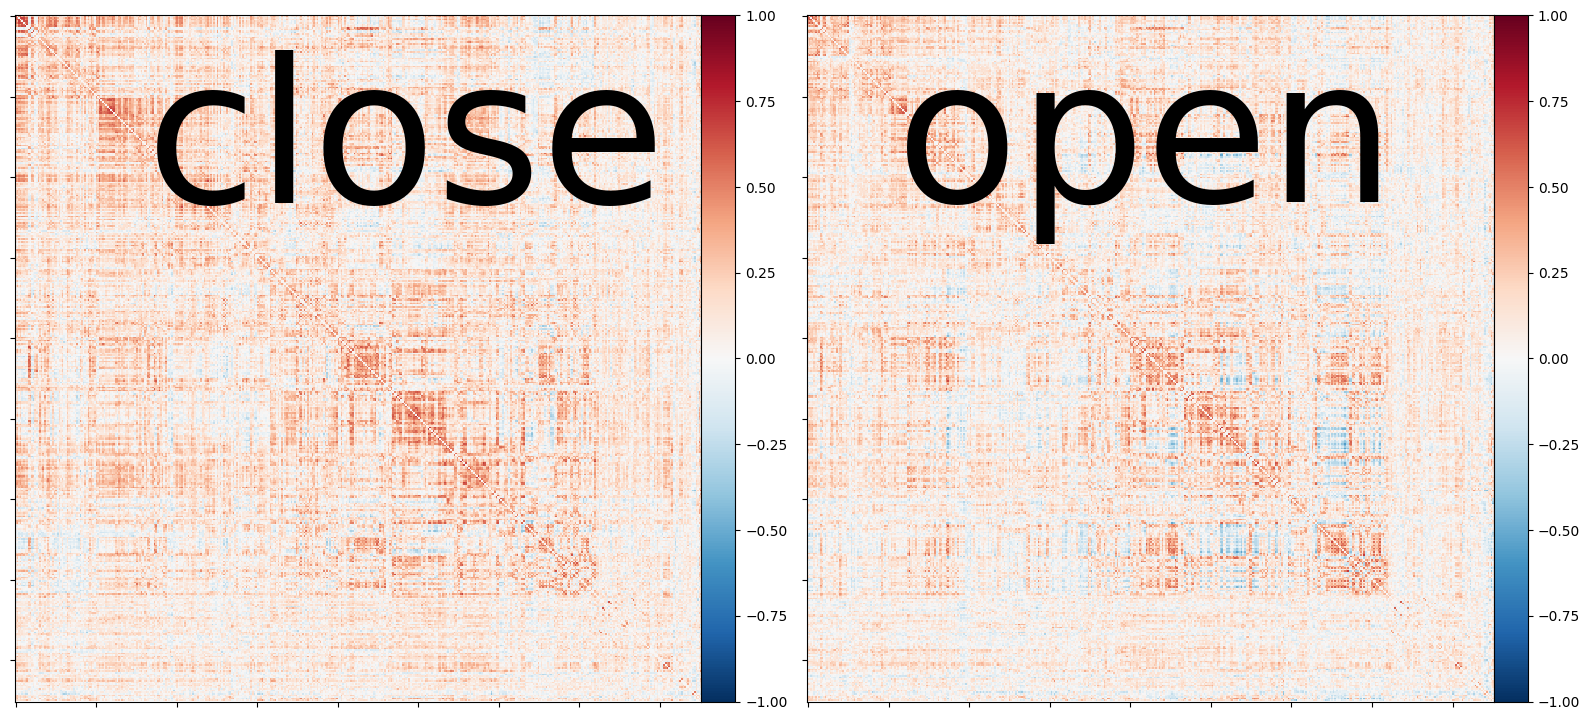

In [70]:
from denoising.helpers import reorder_matrix

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
plotting.plot_matrix(
    reorder_matrix(correlation_matrix[0], dataset.atlas_labels['roi_df'].ID-1),
    labels=None,
    vmax=1,
    vmin=-1,
    title="close",
    reorder=False, axes=ax1)

plotting.plot_matrix(
    reorder_matrix(correlation_matrix[1], dataset.atlas_labels['roi_df'].ID-1),
    labels=None,
    vmax=1,
    vmin=-1,
    title="open ", 
    reorder=False, axes=ax2);
